# Reproducing the experiments from "Evidential Deep Learning" paper

In [1]:
# imports

import os
import os.path as osp
import sys
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from mmengine import Config
from mmengine.dataset import default_collate
from mmpretrain.apis import get_model
from mmpretrain.registry import DATASETS
from mmpretrain.structures import DataSample

import torch
import torchvision.transforms.functional as TF

In [2]:
# include parent path
sys.path.append(os.path.abspath('..'))

In [3]:
# baseline cfg
baseline_cfg = Config.fromfile('../configs/edl_mnist/default_lenet5_mnist.py')
baseline_ckpt = '../work_dirs/default_lenet5_mnist/epoch_30.pth'
assert osp.exists(baseline_ckpt)

# edl cfg
edl_cfg = Config.fromfile('../configs/edl_mnist/edl-sse-relu_lenet5_mnist.py')
edl_ckpt = '../work_dirs/edl-sse-relu_lenet5_mnist/epoch_30.pth'
assert osp.exists(edl_ckpt)

First, we need to create a dataset with a single image and rotate it from 0 to 180 degrees. 

In [4]:
# avoid overwriting the original config
print(baseline_cfg.test_dataloader.dataset)
dataset_cfg: dict = deepcopy(baseline_cfg.test_dataloader.dataset)

# append '../' to the data_prefix
dataset_cfg['data_prefix'] = osp.join('../', dataset_cfg['data_prefix'])

dataset = DATASETS.build(dataset_cfg)
print(type(dataset))

{'type': 'MNIST', 'data_prefix': 'data/mnist', 'pipeline': [{'type': 'Resize', 'scale': 32}, {'type': 'PackInputs'}], 'test_mode': True}
06/07 05:33:30 - mmengine - WARNING - split="train" but test_mode=True. The training set will be used.


/home/ubuntu/.pyenv/versions/3.9.9/envs/uncert/lib/python3.9/site-packages/mmpretrain/datasets/mnist.py:216: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<class 'mmpretrain.datasets.mnist.MNIST'>


In [5]:
# the "1" examples is the 2nd sample in the test dataset
sample = dataset[2]
print(sample['data_samples'].gt_label)

tensor([1])


In [6]:
# Create DataSample of Rotated MNIST

def create_rotated_mnist_sample(sample: dict):
    img: torch.Tensor = sample['inputs']
    data_sample: DataSample = sample['data_samples']

    m = 180
    n = m // 10 + 1
    degs = torch.linspace(0, m, n)
    samples = []
    for deg in degs:
        img_rot = TF.rotate(img.clone(), float(deg), fill=0)
        ds = data_sample.clone()
        ds.set_field(deg, 'rotation', torch.Tensor)
        samples.append(
            dict(
                inputs=img_rot,
                data_samples=ds,
            )
        )

    return samples

samples = create_rotated_mnist_sample(sample)

We need to create a batch of all samples and perform inference on the loaded model.

In [7]:
def make_batch(data: list):
    return default_collate(data)

data = make_batch(samples)

In [8]:
# Load the model
baseline_model = get_model(baseline_cfg, pretrained=baseline_ckpt)
edl_model = get_model(edl_cfg, pretrained=edl_ckpt)

Loads checkpoint by local backend from path: ../work_dirs/default_lenet5_mnist_adam/epoch_30.pth
Loads checkpoint by local backend from path: ../work_dirs/edl-sse-relu_lenet5_mnist_adam/epoch_30.pth


In [9]:
# inference
baseline_model.eval()
baseline_out = baseline_model.test_step(deepcopy(data))

edl_model.eval()
edl_out = edl_model.test_step(deepcopy(data))

print(len(edl_out))
print(edl_out[0])

19
<DataSample(

META INFORMATION
    sample_idx: 2
    img_shape: (32, 32)
    scale_factor: (1.1428571428571428, 1.1428571428571428)
    num_classes: 10

DATA FIELDS
    uncertainty: tensor([0.2324])
    rotation: 0.0
    pred_score: tensor([0.0232, 0.7908, 0.0232, 0.0232, 0.0232, 0.0232, 0.0232, 0.0232, 0.0232,
        0.0232])
    pred_label: tensor([1])
    gt_label: tensor([1])

) at 0x7fcf10e3c0d0>


[ 0. 10.  0.  0.  0.  1.  0.  6.  0.  0.]


<Figure size 620x500 with 0 Axes>

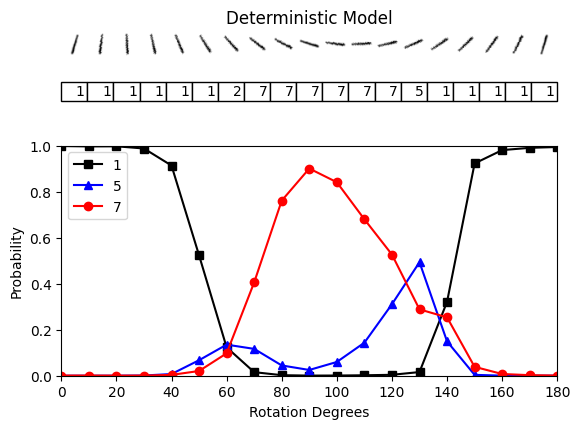

In [10]:
# baseline plot
probs = torch.stack([o.pred_score for o in baseline_out])
preds = probs.argmax(dim=-1)
imgs = torch.cat([s['inputs'] for s in samples], dim=-1).squeeze(0)
degs = torch.stack([o.rotation for o in baseline_out])

threshold = 0.4

# obtain labels where the probability is greater than `threshold`
scores = np.zeros((10))
for o in baseline_out:
    scores += o.pred_score.detach().cpu().numpy() >=  threshold
print(scores)

labels = np.arange(10)[scores.astype(bool)].tolist()
lprobs = np.array(probs.detach().cpu())[:, labels]

fig = plt.figure(figsize=[6.2, 5])
fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    gridspec_kw={"height_ratios": [4, 1, 12]},
)

ax1.imshow(255 - imgs, cmap="gray")
ax1.axis(False)

empty_lst = []
empty_lst.append(preds.tolist())
ax2.table(cellText=empty_lst, bbox=[0, 1.2, 1, 1])
ax2.axis("off")

c = ["black", "blue", "red", "brown", "purple", "cyan"]
marker = ["s", "^", "o"] * 2

for i in range(len(labels)):
    ax3.plot(degs, lprobs[:, i], marker=marker[i], c=c[i])

ax3.set_ylabel("Probability")
ax3.set_xlabel("Rotation Degrees")
ax3.legend(labels)
ax3.set_xlim([0, 180])
ax3.set_ylim([0, 1])

ax1.set_title('Deterministic Model')
plt.show()

[0. 8. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 620x500 with 0 Axes>

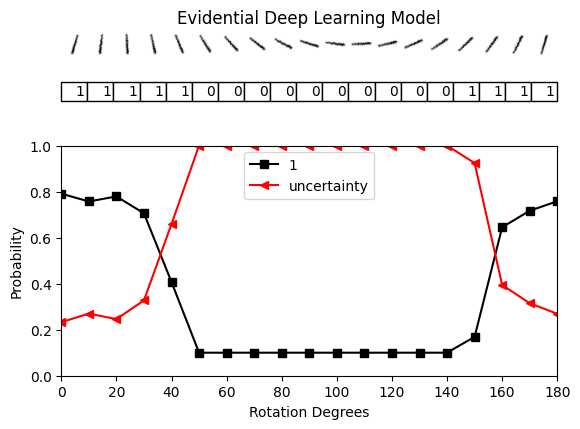

In [11]:
# edl plot
uncertainty = torch.stack([o.uncertainty for o in edl_out])
probs = torch.stack([o.pred_score for o in edl_out])
preds = probs.argmax(dim=-1)
imgs = torch.cat([s['inputs'] for s in samples], dim=-1).squeeze(0)
degs = torch.stack([o.rotation for o in edl_out])

threshold = 0.4

# obtain labels where the probability is greater than `threshold`
scores = np.zeros((10))
for o in edl_out:
    scores += o.pred_score.cpu().numpy() >=  threshold
print(scores)

labels = np.arange(10)[scores.astype(bool)].tolist()
lprobs = np.array(probs.cpu())[:, labels]

fig = plt.figure(figsize=[6.2, 5])
fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    gridspec_kw={"height_ratios": [4, 1, 12]},
)

ax1.imshow(255 - imgs, cmap="gray")
ax1.axis(False)

empty_lst = []
empty_lst.append(preds.tolist())
ax2.table(cellText=empty_lst, bbox=[0, 1.2, 1, 1])
ax2.axis("off")

c = ["black", "blue", "brown", "purple", "cyan", "red"]
marker = ["s", "^", "o"] * 2

for i in range(len(labels)):
    ax3.plot(degs, lprobs[:, i], marker=marker[i], c=c[i])

labels += ["uncertainty"]
ax3.plot(degs, uncertainty, color="red", marker="<")

ax3.set_ylabel("Probability")
ax3.set_xlabel("Rotation Degrees")
ax3.legend(labels)
ax3.set_xlim([0, 180])
ax3.set_ylim([0, 1])

ax1.set_title('Evidential Deep Learning Model')
plt.show()

## Other Experiments (not in the paper)

The experiments are adapted from [pytorch-classification-uncertainty](https://github.com/dougbrion/pytorch-classification-uncertainty).

In [12]:
# imports

from PIL import Image

from mmengine.dataset import Compose
from mmpretrain.registry import TRANSFORMS

In [13]:
# get transform

pipeline = Compose(
    [TRANSFORMS.build(t) for t in baseline_cfg.test_dataloader.dataset.pipeline]
)

In [14]:
one_path = '../data/one.jpg'
one_img = np.array(Image.open(one_path).convert('L'))[..., None]

yoda_path = '../data/yoda.jpg'
yoda_img = np.array(Image.open(yoda_path).convert('L'))[..., None]

infos = [{'img': one_img}, {'img': yoda_img}]
samples = [pipeline(info) for info in infos]
data = make_batch(samples)

In [15]:
# inference
baseline_model.eval()
baseline_out = baseline_model.test_step(deepcopy(data))

edl_model.eval()
edl_out = edl_model.test_step(deepcopy(data))

### Baseline

<Figure size 620x500 with 0 Axes>

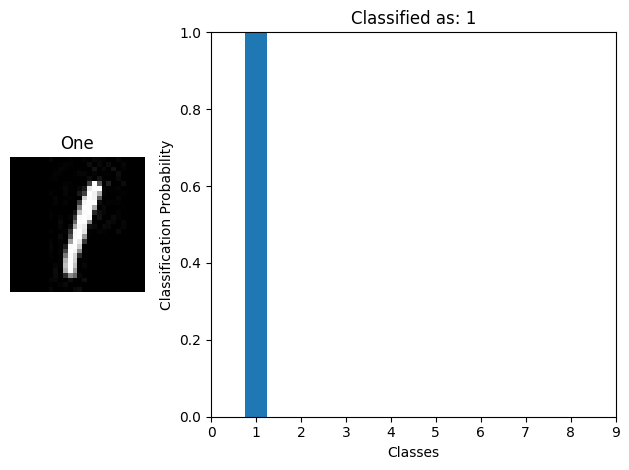

In [16]:
# plot baseline

# one
pred_score = baseline_out[0].pred_score.detach()  # softmax output
pred = pred_score.argmax().item()

labels = np.arange(10)
fig = plt.figure(figsize=[6.2, 5])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

plt.title("Classified as: {}".format(pred))

axs[0].set_title("One")
axs[0].imshow(one_img, cmap="gray")
axs[0].axis("off")

axs[1].bar(labels, pred_score.numpy(), width=0.5)
axs[1].set_xlim([0, 9])
axs[1].set_ylim([0, 1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Classes")
axs[1].set_ylabel("Classification Probability")

fig.tight_layout()

plt.show()

<Figure size 620x500 with 0 Axes>

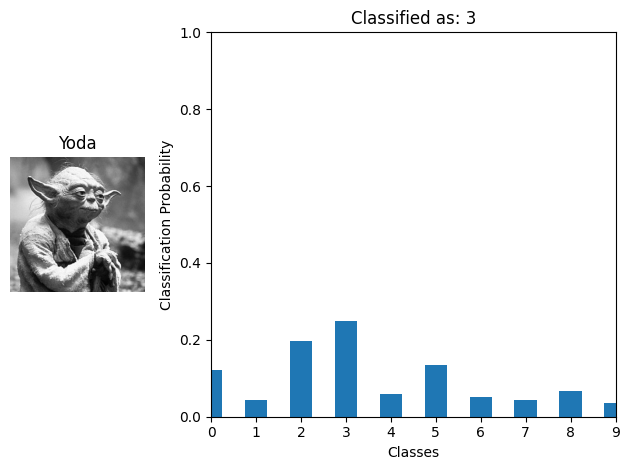

In [17]:
# yoda
pred_score = baseline_out[1].pred_score.detach()  # softmax output
pred = pred_score.argmax().item()

labels = np.arange(10)
fig = plt.figure(figsize=[6.2, 5])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

plt.title("Classified as: {}".format(pred))

axs[0].set_title("Yoda")
axs[0].imshow(yoda_img, cmap="gray")
axs[0].axis("off")

axs[1].bar(labels, pred_score.numpy(), width=0.5)
axs[1].set_xlim([0, 9])
axs[1].set_ylim([0, 1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Classes")
axs[1].set_ylabel("Classification Probability")

fig.tight_layout()

plt.show()

### Evidential Deep Learning

<Figure size 620x500 with 0 Axes>

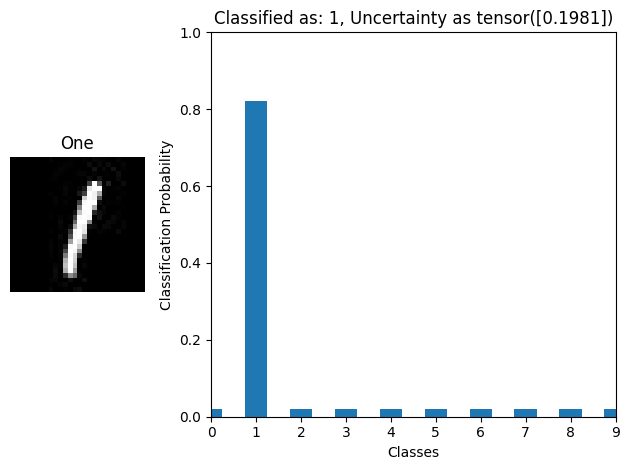

In [18]:
# one
pred_score = edl_out[0].pred_score.detach()  # softmax output
uncertainty = edl_out[0].uncertainty.detach()  # uncertainty
pred = pred_score.argmax().item()

labels = np.arange(10)
fig = plt.figure(figsize=[6.2, 5])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

plt.title("Classified as: {}, Uncertainty as {}".format(pred, uncertainty))

axs[0].set_title("One")
axs[0].imshow(one_img, cmap="gray")
axs[0].axis("off")

axs[1].bar(labels, pred_score.numpy(), width=0.5)
axs[1].set_xlim([0, 9])
axs[1].set_ylim([0, 1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Classes")
axs[1].set_ylabel("Classification Probability")

fig.tight_layout()

plt.show()

<Figure size 620x500 with 0 Axes>

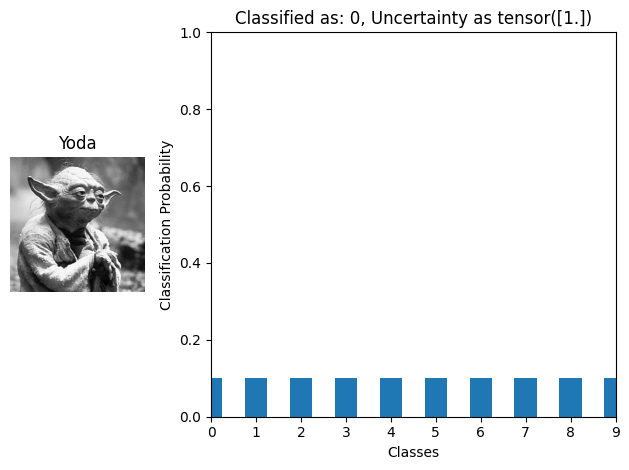

In [19]:
# yoda
pred_score = edl_out[1].pred_score.detach()  # softmax output
uncertainty = edl_out[1].uncertainty.detach()  # uncertainty
pred = pred_score.argmax().item()

labels = np.arange(10)
fig = plt.figure(figsize=[6.2, 5])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

plt.title("Classified as: {}, Uncertainty as {}".format(pred, uncertainty))

axs[0].set_title("Yoda")
axs[0].imshow(yoda_img, cmap="gray")
axs[0].axis("off")

axs[1].bar(labels, pred_score.numpy(), width=0.5)
axs[1].set_xlim([0, 9])
axs[1].set_ylim([0, 1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Classes")
axs[1].set_ylabel("Classification Probability")

fig.tight_layout()

plt.show()